In [302]:
!pip install seaborn==0.9.0
!pip install matplotlib
!pip install numpy

In [303]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import json

from matplotlib import pyplot as plt

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset Experiments

In [304]:
result_path = 'results/artificial_grammar/10_12_2019_20_59_02/dataset_experiments.json'
result_path = 'results/artificial_grammar/10_13_2019_03_23_18/dataset_experiments.json'
dataset_exp_results = json.load(open(result_path))
max_lens = 0
for num_samples in dataset_exp_results:
    arr = dataset_exp_results[num_samples]
    if max_lens < len(dataset_exp_results[num_samples]):
        max_lens = len(dataset_exp_results[num_samples])
print(max_lens)
for num_samples in dataset_exp_results:
    arr = dataset_exp_results[num_samples]
    padding = [None] * (max_lens - len(arr))
    dataset_exp_results[num_samples] = np.array(dataset_exp_results[num_samples] + padding)
dataset_exp_results = pd.DataFrame(dataset_exp_results)


160


(0, 1)

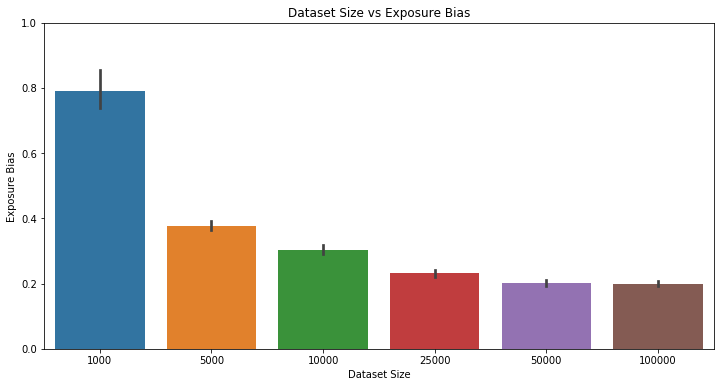

In [305]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(data=dataset_exp_results, ax=ax1)

plt.title('Dataset Size vs Exposure Bias')
ax1.set_xlabel('Dataset Size')
ax1.set_ylabel('Exposure Bias')
ax1.set_ylim(0, 1)




# Validation Experiments

In [369]:
#result_file = 'results/artificial_grammar/10_12_2019_22_07_56/validation_experiments.json'
result_file = 'results/artificial_grammar/10_12_2019_21_00_22/validation_experiments.json'
validation_exp_results = json.load(open(result_file))

# val_ppl_max_len = 0
# for epoch in validation_exp_results:
#     arr = validation_exp_results[epoch]['val_ppl']
#     if val_ppl_max_len < len(arr):
#         val_ppl_max_len = len(arr)

# for epoch in validation_exp_results:
#     arr = validation_exp_results[epoch]['val_ppl']
#     padding = [None] * (val_ppl_max_len - len(arr))
#     validation_exp_results[epoch]['val_ppl'] = np.array(validation_exp_results[epoch]['val_ppl'] + padding)

# exp_bias_max_len = 0
# for epoch in validation_exp_results:
#     arr = validation_exp_results[epoch]['exp_biases']
#     if exp_bias_max_len < len(arr):
#         exp_bias_max_len = len(arr)
    
# for epoch in validation_exp_results:
#     arr = validation_exp_results[epoch]['exp_biases']
#     padding = [None] * (exp_bias_max_len - len(arr))
#     validation_exp_results[epoch]['exp_biases'] = np.array(validation_exp_results[epoch]['exp_biases'] + padding)


for epoch in validation_exp_results:
    validation_exp_results[epoch]['exp_biases'] = np.array(validation_exp_results[epoch]['exp_biases'], dtype=float)
    validation_exp_results[epoch]['val_ppl'] = np.array(validation_exp_results[epoch]['val_ppl'], dtype=float)
    validation_exp_results[epoch]['exp_mean'] = np.mean(validation_exp_results[epoch]['exp_biases'], dtype=float)
    validation_exp_results[epoch]['exp_std'] = np.std(validation_exp_results[epoch]['exp_biases'], dtype=float)
    validation_exp_results[epoch]['val_ppl_mean'] = np.mean(validation_exp_results[epoch]['val_ppl'], dtype=float)
    validation_exp_results[epoch]['val_ppl_std'] = np.std(validation_exp_results[epoch]['val_ppl'], dtype=float)

validation_exp_results = pd.DataFrame(validation_exp_results).T
validation_exp_results = validation_exp_results[:10]
validation_exp_results['exp_mean'] = validation_exp_results['exp_mean'].astype(float)
validation_exp_results['val_ppl_mean'] = validation_exp_results['val_ppl_mean'].astype(float)

# exp_biases = {}
# for key in validation_exp_results:
#     exp_biases[key] = validation_exp_results[key]['exp_biases']

# exp_biases_pd = pd.DataFrame(exp_biases)

# val_ppl = {}
# for key in validation_exp_results:
#     val_ppl[key] = np.mean(validation_exp_results[key]['val_ppl'])
# print(val_ppl)
# val_ppl_pd = pd.DataFrame(val_ppl, index=[0]).T

# exp_biases_pd.mean()
val_ppl_pd

,0
0,2.967610
1,2.955484
2,2.950575
3,2.947707
4,2.946920
5,2.945601
6,2.945073
7,2.941449
8,2.937429
9,2.948125


2019-10-13 15:44:28,075 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2019-10-13 15:44:28,076 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2019-10-13 15:44:28,084 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2019-10-13 15:44:28,085 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


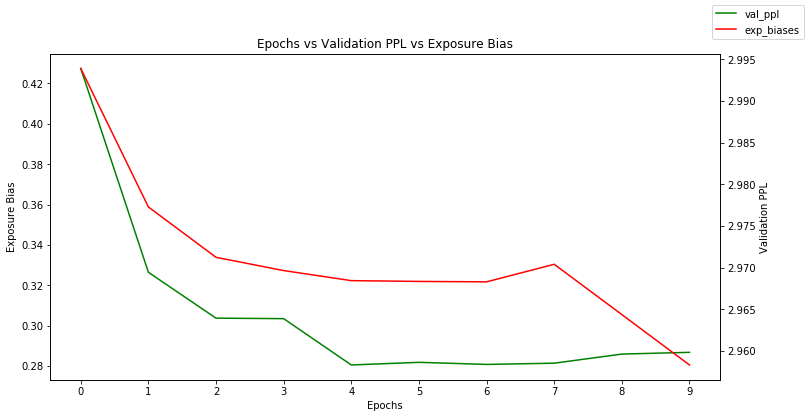

In [370]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111, label='exposure bias')

plt.title('Epochs vs Validation PPL vs Exposure Bias')
ax1.set_xlabel('Epochs')
#sns.boxplot(data=exp_biases_pd, ax=ax1)
#sns.lineplot(data=exp_biases_pd.T, ax=ax1, color='b', err_style='band')
#sns.lineplot(data=validation_exp_results.exp_mean, ax=ax1, err_kws={'exp_mean': validation_exp_results.exp_std})
ax1.errorbar(x=validation_exp_results.index, y=validation_exp_results.exp_mean, color='g')

ax1.set_ylabel('Exposure Bias')
#ax1.set_ylim(0.2,0.6)
ax2 = ax1.twinx()
ax2.errorbar(x=validation_exp_results.index, y=validation_exp_results.val_ppl_mean, color='r')
#sns.boxplot(data=val_ppl_pd, ax=ax2, palette='RdBu')
#sns.lineplot(data=val_ppl_pd, ax=ax2, color='g')
#sns.lineplot(data=validation_exp_results.val_ppl_mean, ax=ax2, color='g', err_style="bars", err_kws={'val_ppl': validation_exp_results.val_ppl_std})

ax2.set_ylabel('Validation PPL')
ax2.yaxis.set_label_position('right')


fig.legend(['val_ppl', 'exp_biases'])
#ax2.set_ylim(2.8,3.2)


# Model Size Experiments

# Beam Search Experiments